In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Homework description

Take data from kaggle housing.
1. Confident ellipsoids by sampling
    - Create each model from the list [linear,ridge] H=1000 times on subsamples (test_size=20%)
    - Collect train and test metrics
    - Build 2D confident sets for metrics and visualize them (2 model -> two 2D
sets)
2. Do the same using jackknife
3. Fit stacked generalization for both models and try in kaggle

In [64]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [65]:
y_train = np.log(train_data['SalePrice'])

In [66]:
def rmse(a, b):
    return ((a - b) ** 2).mean() ** 0.5

In [67]:
numeric_columns = [i for i, j in zip(train_data.columns, train_data.dtypes) if j in [np.int64, np.float64] and i not in ['SalePrice', 'Id']]
x_train = train_data[numeric_columns].fillna(-1)
x_test = test_data[numeric_columns].fillna(-1)

In [68]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
H = 1000

def get_metrics(model):
    metrics = []
    for h in tqdm(range(H)):
        x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2)
        model = model.fit(x_tr, y_tr)
        y_pred_tr = model.predict(x_tr)
        y_pred_val = model.predict(x_val)

        metrics.append({
            'algorithm' : f'{type(model).__name__}',
            'train_mse' : rmse(y_pred_tr, y_tr),
            'val_mse' : rmse(y_pred_val, y_val),
        })
        
    return metrics

linear_metrics = pd.DataFrame(get_metrics(LinearRegression()))
linear_metrics

100%|██████████| 1000/1000 [00:33<00:00, 30.05it/s]


,algorithm,train_mse,val_mse
0,LinearRegression,0.148604,0.131711
1,LinearRegression,0.140861,0.162462
2,LinearRegression,0.149305,0.129117
3,LinearRegression,0.141605,0.161284
4,LinearRegression,0.149741,0.127035
...,...,...,...
995,LinearRegression,0.147658,0.153505
996,LinearRegression,0.144831,0.151169
997,LinearRegression,0.133631,0.203022
998,LinearRegression,0.117475,0.253334


In [69]:
from scipy.stats import chi2

alpha = 0.05
r = chi2.ppf(1 - alpha, 2) ** 0.5

Based on scikit-learn docs:

In [70]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [23]:
ridge_metrics = pd.DataFrame(get_metrics(Ridge()))
ridge_metrics

100%|██████████| 1000/1000 [00:20<00:00, 49.13it/s]


,algorithm,train_mse,val_mse
0,Ridge,0.146653,0.144775
1,Ridge,0.146973,0.142019
2,Ridge,0.146557,0.141688
3,Ridge,0.144371,0.152998
4,Ridge,0.134039,0.201215
...,...,...,...
995,Ridge,0.134887,0.199944
996,Ridge,0.144642,0.151266
997,Ridge,0.146597,0.140501
998,Ridge,0.145454,0.146411


Intersection of Linear and Ridge Regression with alpha = 1 (default)

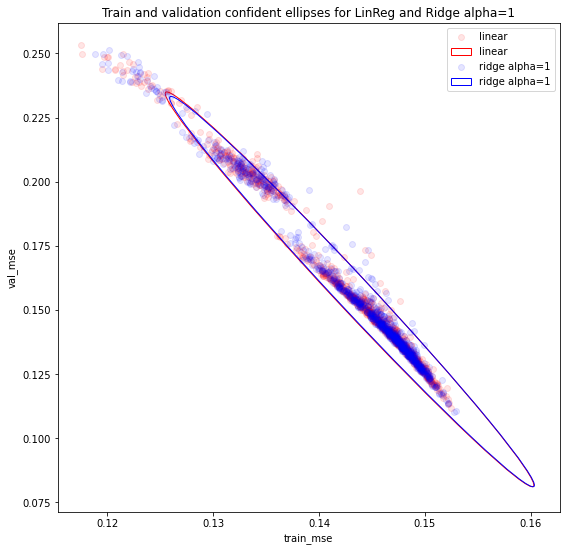

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.scatter(linear_metrics['train_mse'], linear_metrics['val_mse'], c='red', alpha=0.1)
confidence_ellipse(linear_metrics['train_mse'], linear_metrics['val_mse'], ax, n_std=r, edgecolor='red')
ax.scatter(ridge_metrics['train_mse'], ridge_metrics['val_mse'], c='blue', alpha=0.1)
confidence_ellipse(ridge_metrics['train_mse'], ridge_metrics['val_mse'], ax, n_std=r, edgecolor='blue')
ax.set_xlabel('train_mse')
ax.set_ylabel('val_mse')
ax.legend(['linear', 'linear', 'ridge alpha=1', 'ridge alpha=1'])
ax.set_title('Train and validation confident ellipses for LinReg and Ridge alpha=1')
plt.show()

Outcome notes:
- nearly the same

In [27]:
ridge_100_metrics = pd.DataFrame(get_metrics(Ridge(alpha=100)))
ridge_100_metrics

100%|██████████| 1000/1000 [00:20<00:00, 49.29it/s]


,algorithm,train_mse,val_mse
0,Ridge,0.149264,0.134086
1,Ridge,0.148062,0.140513
2,Ridge,0.148918,0.137426
3,Ridge,0.148003,0.140905
4,Ridge,0.145460,0.150903
...,...,...,...
995,Ridge,0.146316,0.146389
996,Ridge,0.147811,0.139544
997,Ridge,0.151115,0.124342
998,Ridge,0.144519,0.153262


Intersection of Linear and Ridge Regression with alpha = 1 (default)

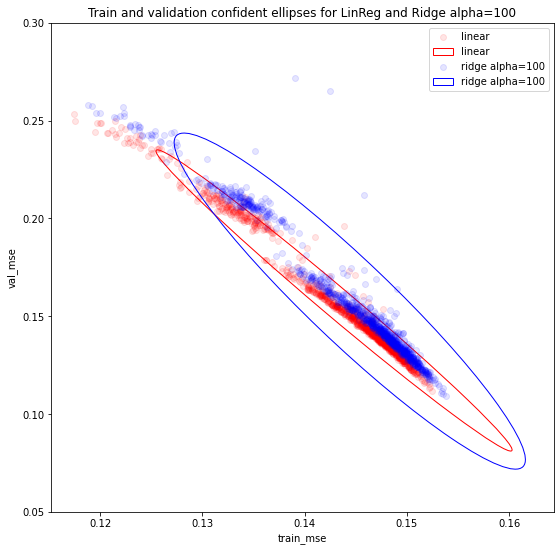

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.scatter(linear_metrics['train_mse'], linear_metrics['val_mse'], c='red', alpha=0.1)
confidence_ellipse(linear_metrics['train_mse'], linear_metrics['val_mse'], ax, n_std=r, edgecolor='red')
ax.scatter(ridge_100_metrics['train_mse'], ridge_100_metrics['val_mse'], c='blue', alpha=0.1)
confidence_ellipse(ridge_100_metrics['train_mse'], ridge_100_metrics['val_mse'], ax, n_std=r, edgecolor='blue')
ax.set_xlabel('train_mse')
ax.set_ylabel('val_mse')
ax.set_ylim((0.05, 0.3))
ax.legend(['linear', 'linear', 'ridge alpha=100', 'ridge alpha=100'])
ax.set_title('Train and validation confident ellipses for LinReg and Ridge alpha=100')
plt.show()

Outcome notes:
- linear regression is more stable
- mostly similar models' performances, but but in some small part of cases they can be different

### Jackknife (Leave One Out)

In [90]:
H = 1000

def get_jackknife_metrics(models):
    metrics = []
    x_train_numpy = x_train.to_numpy()
    y_train_numpy = y_train.to_numpy()
    for i in tqdm(range(x_train_numpy.shape[0])):
        x_tr = np.delete(x_train_numpy, [i], axis=0)
        y_tr = np.delete(y_train_numpy, [i])
        x_val = x_train_numpy[[i]]
        y_val = y_train_numpy[i]
        for model_name, model in models.items():
            model = model.fit(x_tr, y_tr)
            y_pred_tr = model.predict(x_tr)
            y_pred_val = model.predict(x_val)

            metrics.append({
                'algorithm' : model_name,
                'train_mse' : rmse(y_pred_tr, y_tr),
                'val_mse' : rmse(y_pred_val, y_val),
            })
        
    return metrics

models = {
    'Linear' : LinearRegression(),
    'Ridge alpha=1' : Ridge(),
    'Ridge alpha=100' : Ridge(alpha=100)
}

jack_metrics = get_jackknife_metrics(models)
jack_metrics = pd.DataFrame(jack_metrics)
jack_metrics

,algorithm,train_mse,val_mse
0,Linear,0.144882,0.008065
1,Ridge alpha=1,0.144883,0.007867
2,Ridge alpha=100,0.145768,0.000313
3,Linear,0.144867,0.080786
4,Ridge alpha=1,0.144868,0.080315
...,...,...,...
4375,Ridge alpha=1,0.144866,0.085277
4376,Ridge alpha=100,0.145754,0.071991
4377,Linear,0.144882,0.018289
4378,Ridge alpha=1,0.144882,0.018393


In [98]:
linear_jack_metrics = jack_metrics[jack_metrics['algorithm'] == 'Linear']
ridge_jack_metrics = jack_metrics[jack_metrics['algorithm'] == 'Ridge alpha=1']
ridge_100_jack_metrics = jack_metrics[jack_metrics['algorithm'] == 'Ridge alpha=100']
linear_jack_metrics

,algorithm,train_mse,val_mse
0,Linear,0.144882,0.008065
3,Linear,0.144867,0.080786
6,Linear,0.144880,0.033271
9,Linear,0.144791,0.200040
12,Linear,0.144815,0.169391
...,...,...,...
4365,Linear,0.144879,0.036420
4368,Linear,0.144846,0.125436
4371,Linear,0.144804,0.186221
4374,Linear,0.144866,0.085536


In [99]:
ridge_jack_metrics

,algorithm,train_mse,val_mse
1,Ridge alpha=1,0.144883,0.007867
4,Ridge alpha=1,0.144868,0.080315
7,Ridge alpha=1,0.144880,0.033381
10,Ridge alpha=1,0.144791,0.199436
13,Ridge alpha=1,0.144816,0.169153
...,...,...,...
4366,Ridge alpha=1,0.144880,0.036322
4369,Ridge alpha=1,0.144846,0.125166
4372,Ridge alpha=1,0.144804,0.186203
4375,Ridge alpha=1,0.144866,0.085277


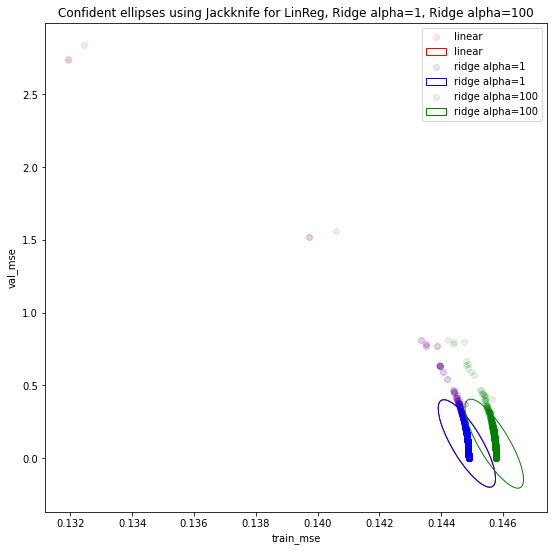

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

ax.scatter(linear_jack_metrics['train_mse'], linear_jack_metrics['val_mse'], c='red', alpha=0.1)
confidence_ellipse(linear_jack_metrics['train_mse'], linear_jack_metrics['val_mse'], ax, n_std=r, edgecolor='red')

ax.scatter(ridge_jack_metrics['train_mse'], ridge_jack_metrics['val_mse'], c='blue', alpha=0.1)
confidence_ellipse(ridge_jack_metrics['train_mse'], ridge_jack_metrics['val_mse'], ax, n_std=r, edgecolor='blue')

ax.scatter(ridge_100_jack_metrics['train_mse'], ridge_100_jack_metrics['val_mse'], c='green', alpha=0.1)
confidence_ellipse(ridge_100_jack_metrics['train_mse'], ridge_100_jack_metrics['val_mse'], ax, n_std=r, edgecolor='green')

ax.set_xlabel('train_mse')
ax.set_ylabel('val_mse')
ax.legend(['linear', 'linear', 'ridge alpha=1', 'ridge alpha=1','ridge alpha=100', 'ridge alpha=100'])
ax.set_title('Confident ellipses using Jackknife for LinReg, Ridge alpha=1, Ridge alpha=100')

plt.show()

Focus on ellipsoids on the next plot

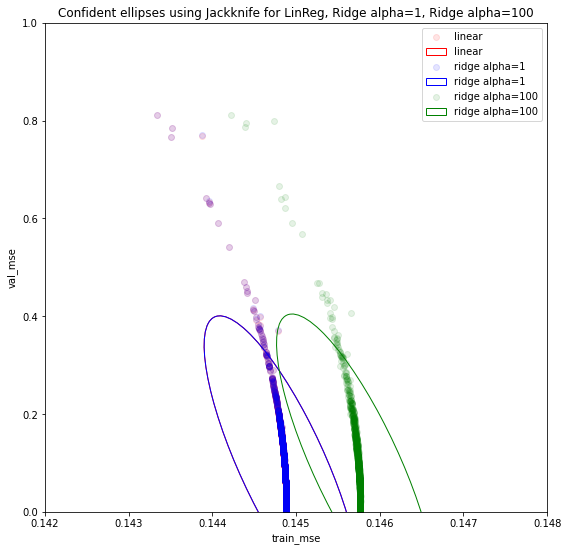

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

ax.scatter(linear_jack_metrics['train_mse'], linear_jack_metrics['val_mse'], c='red', alpha=0.1)
confidence_ellipse(linear_jack_metrics['train_mse'], linear_jack_metrics['val_mse'], ax, n_std=r, edgecolor='red')

ax.scatter(ridge_jack_metrics['train_mse'], ridge_jack_metrics['val_mse'], c='blue', alpha=0.1)
confidence_ellipse(ridge_jack_metrics['train_mse'], ridge_jack_metrics['val_mse'], ax, n_std=r, edgecolor='blue')

ax.scatter(ridge_100_jack_metrics['train_mse'], ridge_100_jack_metrics['val_mse'], c='green', alpha=0.1)
confidence_ellipse(ridge_100_jack_metrics['train_mse'], ridge_100_jack_metrics['val_mse'], ax, n_std=r, edgecolor='green')

ax.set_xlabel('train_mse')
ax.set_ylabel('val_mse')
ax.set_ylim((0, 1))
ax.set_xlim((0.142, 0.148))

ax.legend(['linear', 'linear', 'ridge alpha=1', 'ridge alpha=1','ridge alpha=100', 'ridge alpha=100'])
ax.set_title('Confident ellipses using Jackknife for LinReg, Ridge alpha=1, Ridge alpha=100')

plt.show()

Outcome notes:
- linear regression and ridge regression with alpha=1 almost identical
- ridge with alpha=100 is different
- test performances are the same

### Boostrap vs Jackknife

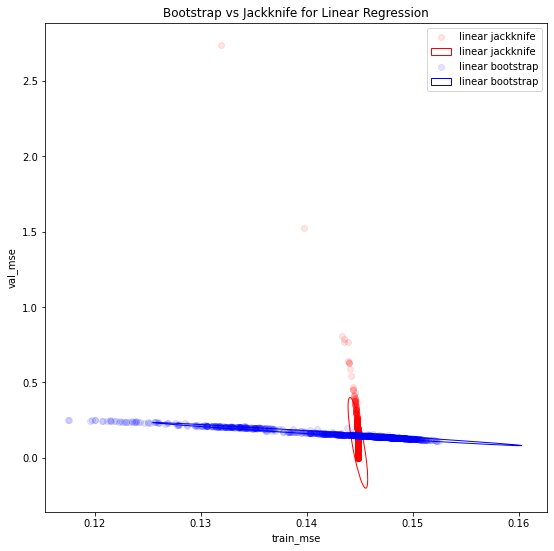

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

ax.scatter(linear_jack_metrics['train_mse'], linear_jack_metrics['val_mse'], c='red', alpha=0.1)
confidence_ellipse(linear_jack_metrics['train_mse'], linear_jack_metrics['val_mse'], ax, n_std=r, edgecolor='red')

ax.scatter(linear_metrics['train_mse'], linear_metrics['val_mse'], c='blue', alpha=0.1)
confidence_ellipse(linear_metrics['train_mse'], linear_metrics['val_mse'], ax, n_std=r, edgecolor='blue')

ax.set_xlabel('train_mse')
ax.set_ylabel('val_mse')

ax.legend(['linear jackknife', 'linear jackknife', 'linear bootstrap', 'linear bootstrap'])
ax.set_title('Bootstrap vs Jackknife for Linear Regression')

plt.show()

Outcome notes:
- bootstrap's variance is smaller - it's more stable approach to evaluate model
- jackknife might give more optimistic evaluation of the model

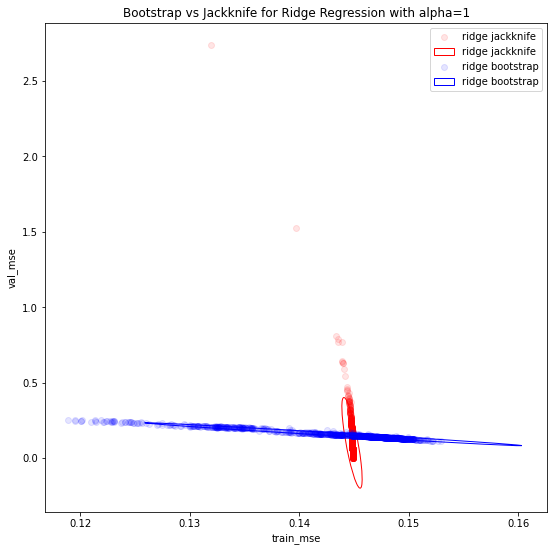

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

ax.scatter(ridge_jack_metrics['train_mse'], ridge_jack_metrics['val_mse'], c='red', alpha=0.1)
confidence_ellipse(ridge_jack_metrics['train_mse'], ridge_jack_metrics['val_mse'], ax, n_std=r, edgecolor='red')

ax.scatter(ridge_metrics['train_mse'], ridge_metrics['val_mse'], c='blue', alpha=0.1)
confidence_ellipse(ridge_metrics['train_mse'], ridge_metrics['val_mse'], ax, n_std=r, edgecolor='blue')

ax.set_xlabel('train_mse')
ax.set_ylabel('val_mse')

ax.legend(['ridge jackknife', 'ridge jackknife', 'ridge bootstrap', 'ridge bootstrap'])
ax.set_title('Bootstrap vs Jackknife for Ridge Regression with alpha=1')

plt.show()

Outcome notes:
- bootstrap's variance is smaller - it's more stable approach to evaluate model
- jackknife might give more optimistic evaluation of the model

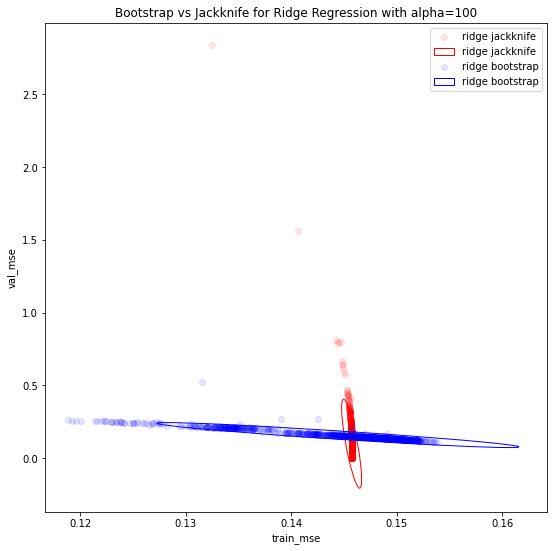

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

ax.scatter(ridge_100_jack_metrics['train_mse'], ridge_100_jack_metrics['val_mse'], c='red', alpha=0.1)
confidence_ellipse(ridge_100_jack_metrics['train_mse'], ridge_100_jack_metrics['val_mse'], ax, n_std=r, edgecolor='red')

ax.scatter(ridge_100_metrics['train_mse'], ridge_100_metrics['val_mse'], c='blue', alpha=0.1)
confidence_ellipse(ridge_100_metrics['train_mse'], ridge_100_metrics['val_mse'], ax, n_std=r, edgecolor='blue')

ax.set_xlabel('train_mse')
ax.set_ylabel('val_mse')

ax.legend(['ridge jackknife', 'ridge jackknife', 'ridge bootstrap', 'ridge bootstrap'])
ax.set_title('Bootstrap vs Jackknife for Ridge Regression with alpha=100')

plt.show()

Outcome notes:
- jackknife's ellipsoid is smaller - jackknife might result in more stable results
- jackknife might give more optimistic evaluation of the model

TODO: Fit stacked generalization (once again, own implementation based on the module's main book) for both models